# TP DE ICV - COMPRESSÃO DE IMAGENS
## Integrantes da dupla
João Lucas Simões Moreira,
Raphael Aroldo Carreiro Mendes

## Compressões realizadas
DCT + RLE + Huffman

DWT + RLE + Huffman

## Informações importantes
Ao final de 'Tópico DCT' e 'Tópico DWT' se encontra uma célula para a execução da compactação. Manipule o **img_name para** receber o nome da imagem original e o **compacted_img_name** para receber o nome do arquivo que receberá a compactação.


#Imports e definições auxiliares

Funções para PSNR, MSE, Entropia, e RLE

In [510]:
import scipy
import sklearn
import re
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import os.path
import json
import ast

from heapq import heappush, heappop, heapify
from collections import defaultdict
from scipy.fftpack import dct, idct
from skimage import data, color
from PIL import Image
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc # pip install Pillow
import pywt
import pywt.data
from collections import Counter

In [511]:
"""
  Função que calcula a entropia da imagem

  :param img: imagem a ser calculada

"""
def entropiacalc(img):
  values = img.astype(np.float32).flatten()

  counter_values = Counter(values).most_common()

  probabilities = [elem[1]/len(values) for elem in counter_values]
  entropy = scipy.stats.entropy(probabilities)

  return entropy

In [512]:
"""
  Função para calcular o Erro Médio Quadrático (Mean Square Error) da imagem.
"""
def MSE_calc(original, reconstruida):
  MSE = np.sum((original-reconstruida)**2)/original.size
  return np.round(MSE,2)

In [513]:
"""
  Função para calcular o PSNR (Peak Signal-to-Noise Ratio) da imagem
"""
def PSNR_calc(original, reconstruida):
  PSNR = 10*np.log10((255**2)/(MSE_calc(original,reconstruida)))
  return np.round(PSNR,2)

In [514]:
"""
    Função para codificar uma matriz usando Running Length
"""
def rle_encode(matrix):

  x_tam, y_tam = matrix.shape
  tuplas_lista = []
  matriz_listas = []

  for i in range(x_tam):
    valor = matrix[i][0]
    contador = 1
    for j in range (1,y_tam):
      if (matrix[i][j] != valor):
        tuplas_lista.append((valor, contador))
        valor = matrix[i][j]
        contador = 1
        if (j == y_tam-1):
          tuplas_lista.append((valor, contador))
      else:
        contador += 1
        if (j == y_tam-1):
          tuplas_lista.append((valor,contador))
    matriz_listas.append(tuplas_lista)
    tuplas_lista = []

  return matriz_listas


In [515]:
"""
    Função para decodificar uma matriz usando Running Length
"""
def rle_decode_to_ndarray(codificado):

  matriz_como_lista = []

  for row_tuples in codificado:
    linha_original = []
    for valor, contagem in row_tuples:
      linha_original += ([valor] * contagem)
    matriz_como_lista.append(linha_original)

  matriz_numpy = np.array(matriz_como_lista)

  return matriz_numpy

In [516]:
"""
    Função para reconstruir uma matriz a partir de
"""
def refaz(matriz_string):
  matriz = []
  for linhas_na_string in matriz_string.split(' '):
    lista_linha = []
    for tuplas in linhas_na_string.split(','):
      # print(tuplas)
      tup = tuplas.split(':')
      if(len(tup) != 2):
        break
      if (tup[0] == ''):
        continue
      if (tup[1] == ''):
        continue
      valor = int(tup[0])
      count = int(tup[1])
      lista_linha.append((valor,count))
      # print(lista_linha)
    if (lista_linha == []):
      continue
    matriz.append(lista_linha)

  return matriz

#Huffman

### Huffman e todos os auxiliares

Todas as funções e classes envolvendo o huffman, como os nós
e as funções de escrita e leitura de arquivo

In [517]:
""" Classe do nó da árvore """
class Node:
    """
        Construtor da classe

        :param self: nó atual
        :param value: valor do símbolo do nó
        :param freq: frequência do símbolo
    """
    def __init__(self, value, freq):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None

    """
        Função de comparação entre dois nós

        :param self: nó atual
        :param other: nó a ser comparado
    """
    def __lt__(self, other):
        return self.freq < other.freq

In [518]:
"""
    Função que executa a codificação de Huffman

    :param symbol_frequency: dicionário que contém um símbolo e a frequência que ele aparece
"""
def Encode(symbols_frequency):
    heap = [Node(value, freq) for value, freq in symbols_frequency.items()]
    heapify(heap)
    while len(heap) > 1:
        left = heappop(heap)
        right = heappop(heap)
        parent = Node(None, left.freq + right.freq)
        parent.left = left
        parent.right = right
        heappush(heap, parent)

    return heap[0]

In [519]:
"""
    Função que executa a decodificação de Huffman

    :param encoded_data: string em binário
    :param root: raiz da árvore de Huffman
    :param length: tamanho da string original
"""
def Decode(encoded_data, root, length):
    current = root
    decoded_string = ""
    aux_length = 0
    for bit in encoded_data:
        if bit == '0':
            current = current.left
        else:
            current = current.right
        if current.value is not None:
            if (aux_length == length):
                break
            if (current.value == (ord(' ') + 10000)):
                decoded_string += ' '
            elif (current.value == (ord(',') + 10000)):
                decoded_string += ','
            elif (current.value == (ord(':') + 10000)):
                decoded_string += ':'
            elif current.value != '':
                decoded_string += str(current.value)
            else:
                continue
            aux_length += 1
            current = root

    return decoded_string

In [520]:
"""
    Função que gera os códigos de Huffman

    :param root: raiz da árvore de Huffman
    :param current_code: string em binário
    :param result: dicionário de códigos
"""
def GenerateHuffmanCodes(root, current_code="", result={}):
    if root is None:
        return

    if root.value is not None:
        result[root.value] = current_code

    GenerateHuffmanCodes(root.left, current_code + "0", result)
    GenerateHuffmanCodes(root.right, current_code + "1", result)

In [521]:
"""
    Função que escreve um arquivo

    :param encoded_string: string contendo os códigos binários
    :param huffman_dict: dicionário das frequências utilizadas em Huffman
    :param file_name: arquivo a ser lido
"""
def WriteFile(encoded_string, huffman_dict, size, file_name):
    encoded_bytes = bytes(int(encoded_string[i:i+8], 2) for i in range(0, len(encoded_string), 8))
    with open(file_name, "wb") as file:
        file.write(encoded_bytes)
        file.write(b'ganso!')
        file.write(f"{size[0]}, {size[1]}".encode('utf-8'))
        file.write(b'salame!')
        for key, value in huffman_dict.items():
            file.write(f"{(key)}: {(value)}\n".encode('utf-8'))

In [522]:
"""
    Função que lê um arquivo

    :param file_name: arquivo a ser lido
"""
def ReadFile(file_name):
    decoded_string = ""
    huffman_dict = defaultdict(float)

    with open(file_name, "rb") as file:
        binary_data = file.read()
        newline_position = binary_data.find(b'ganso!')
        new_newline_position = binary_data.find(b'salame!')
        binary_decoded_string = binary_data[:newline_position]
        binary_height_width = binary_data[newline_position + 6:new_newline_position]
        binary_freq_dict = binary_data[new_newline_position + 7:]

        decoded_string = ''.join(format(byte, '08b') for byte in binary_decoded_string)
        size = binary_height_width.decode('utf-8').split(',')
        height = size[0]
        width = size[1]
        binary_freq_dict = binary_freq_dict.decode('utf-8').split('\n')
        for line in binary_freq_dict:
            if (line == ''):
                continue
            key, value = map(float, line.strip().split(":"))
            huffman_dict[int(key)] = value

    return decoded_string, huffman_dict, (int(height), int(width))

In [523]:
"""
    Função que aplica Huffman e escreve um arquivo compactado

    :param matrix: matriz a ser compactada
    :param base_tam: tamanho original da matriz
    :param compressed_file_name: nome do arquivo compactado
"""
def HuffmanWriteTest(matrix, base_tam, compressed_file_name):
    # Salvando dados da imagem original
    rle_string = ""
    height, width = base_tam
    symbols_freq_dict = defaultdict(int)
    normalized_symbols_freq_dict = defaultdict(int)

    for row in matrix:
        for value, count in row:
            rle_string += str(value) + ":" + str(count) + ","
        rle_string += ' '

    for word in rle_string.split(' '):
        # print(word)
        for number in word.split(','):
            current_number = number.split(':')
            if (current_number[0] == '' or current_number[1] == ''):
                continue
            symbols_freq_dict[int(current_number[0])] += 1
            symbols_freq_dict[int(current_number[1])] += 1
            symbols_freq_dict[ord(':') + 10000] += 1
            symbols_freq_dict[ord(',') + 10000] += 1
        symbols_freq_dict[ord(' ') + 10000] += 1

    for elements in symbols_freq_dict:
        normalized_symbols_freq_dict[elements] = symbols_freq_dict[elements] / (height*width)

    huff = Encode(normalized_symbols_freq_dict)
    huffman_dict = defaultdict(float)
    GenerateHuffmanCodes(huff,"",huffman_dict)

    Lbarra  = 0
    for elemento in normalized_symbols_freq_dict:
        Lbarra += normalized_symbols_freq_dict[elemento] * len(huffman_dict[elemento])
    print("Lbarra:", Lbarra)

    encoded_string = ""
    for word in rle_string.split(' '):
        for number in word.split(','):
            current_number = number.split(':')
            if (current_number[0] == '' or current_number[1] == ''):
                continue
            encoded_string += str(huffman_dict[int(current_number[0])])
            encoded_string += str(huffman_dict[ord(':') + 10000])
            encoded_string += str(huffman_dict[int(current_number[1])])
            encoded_string += str(huffman_dict[ord(',') + 10000])
        encoded_string += str(huffman_dict[ord(' ') + 10000])

    WriteFile(encoded_string,symbols_freq_dict,(height,width),compressed_file_name)

In [524]:
"""
    Função que lê um arquivo compactado e aplica Huffman para descompactar

    :param compressed_file_name: nome do arquivo compactado
"""
def HuffmanReadTest(compressed_file_name):
    # Lendo a tabela de frequências, o binário compactado e gerando a codificação de huffman
    new_encoded_string, new_symbols_frequency, size = ReadFile(compressed_file_name)
    new_huff = Encode(new_symbols_frequency)
    length = 0
    for elements in new_symbols_frequency:
        length += new_symbols_frequency[elements]
        new_symbols_frequency[elements] = new_symbols_frequency[elements] / (size[0]*size[1])

    new_huff = Encode(new_symbols_frequency)
    decoded_string = Decode(new_encoded_string, new_huff, length)

    return decoded_string, size

#Tópico DCT

##Funções Auxiliares

DCT Bidimensional (2D), Versão em blocos 8x8 e Quantização/Dequantização da imagem.

###Funções DCT bidimensional e inversas bidimensionais (DCT-2D)

In [525]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

###Funções de DCT em blocos 8x8 - Decomposição e Reconstrução

Função DCT em blocos 8x8 da imagem original.

Retorna uma imagem com as dimensões da imagem original, dividida em blocos de DCT 8x8.

Espera uma imagem pré-processada, apenas pronta para a rotação no centro do espaço n-dimensional.

In [526]:
def dct_8x8(imagem_param):
  imgsize = imagem_param.shape
  result = np.zeros(imgsize, dtype=float)

  #Aplicando DCT nos blocos 8x8 da imagem (inplace)
  for i in r_[:imgsize[0]:8]:
    for j in r_[ :imgsize[1]:8]:
      result[i:(i+8),j:(j+8)] = dct2(imagem_param[i:(i+8), j:(j+8)])

  return result

In [527]:
def inverse_dct_8x8(dctimg_param):
  imgsize = dctimg_param.shape
  result = np.zeros(imgsize, dtype=float)

  #Aplicando a DCT inversa nos blocos 8x8 da imagem (inplace)
  for i in r_[ :imgsize[0]:8]:
    for j in r_[ :imgsize[1]:8]:
      result[i:(i+8), j:(j+8)] = idct2(dctimg_param[i:(i+8), j:(j+8)])

  return result

###Funções de Quantização e Dequantização dos Blocos 8x8

Funções auxiliares para quantizar e desquantizar os blocos 8x8 com o uso da matriz de quantização QM.

In [528]:
def quantiza(dctimg_param):
  imgsize = dctimg_param.shape
  result = np.zeros(imgsize, dtype=float)
  result = result.astype(float)

  QM = np.matrix([[16, 13, 11, 19, 31, 40, 51, 61],
                [14, 14, 16, 23, 32, 58, 60, 55],
                [17, 15, 19, 27, 44, 57, 69, 56],
                [17, 21, 26, 34, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

  QM = QM.astype(float)

  for i in r_[ :imgsize[0]:8]:
    for j in r_[ :imgsize[1]:8]:
      bloco_quantizado = np.divide(dctimg_param[i:(i+8), j:(j+8)], QM)
      bloco_quantizado = np.round(bloco_quantizado)
      result[i:(i+8), j:(j+8)] = bloco_quantizado

  return result

In [529]:
def de_quantiza(quantized):
  imgsize = quantized.shape
  result = np.zeros(imgsize, dtype=float)
  result = result.astype(float)

  QM = np.matrix([[16, 13, 11, 19, 31, 40, 51, 61],
                [14, 14, 16, 23, 32, 58, 60, 55],
                [17, 15, 19, 27, 44, 57, 69, 56],
                [17, 21, 26, 34, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

  QM = QM.astype(float)

  for i in r_[ :imgsize[0]:8]:
    for j in r_[ :imgsize[1]:8]:
      dequantizado_8x8 = np.multiply(quantized[i:(i+8), j:(j+8)],QM)
      dequantizado_8x8 = dequantizado_8x8.round()
      result[i:(i+8), j:(j+8)] = dequantizado_8x8

  return result

##Compressões e Testes Finais

###Compressão por DCT

Compressão e Resultados Finais

In [530]:
"""
    Função que recebe o arquivo comprimido e descomprime usando DCT

    :param imagem: imagem a ser compactada
    :param nome_arquivo_comprimido: arquivo compactado
"""
def DCTWrite(imagem, nome_arquivo_comprimido):
  height, width = imagem.shape

  original = imagem
  base = original.astype(np.int16) ##alterando para centralizar o ponto no espaço
  base = np.subtract(base, 128) ##centralizando e preparando para rotação utilizando as transformadas

  blocos_8x8 = dct_8x8(base) ##Aplicando DCT em blocos 8x8 da imagem original
  quantizado = quantiza(blocos_8x8)
  quantizado = quantizado.astype(np.int16) ##quantização e truncamento de informação

  fig1 = plt.figure(figsize=(10,7))
  fig1.add_subplot(1,2,1)
  plt.imshow(np.log(1+np.abs(quantizado)), cmap='gray')
  plt.axis('off')
  plt.title("Imagem original divida em blocos 8x8 - DCT")

  pos = 160
  fig1.add_subplot(1,2,2)
  plt.imshow(1+np.abs(quantizado[pos:pos+8, pos:pos+8]),cmap='gray')
  plt.title("Bloco 8x8 - (0,0) = (160,160) na imagem original")
  plt.axis('off')

  entrop = entropiacalc(quantizado)
  print(f"Entropia da imagem em blocos 8x8 é: {entrop}",'\n')

  quantizado = rle_encode(quantizado)
  HuffmanWriteTest(quantizado, imagem.shape, nome_arquivo_comprimido)

In [531]:
"""
    Função que recebe o arquivo comprimido e descomprime usando DCT

    :param original: imagem original utilizada APENAS PARA calcular PSNR e MSE
    :param nome_arquivo_comprimido: arquivo compactado
"""
def DCTRead(original, nome_arquivo_comprimido):
    string_mat_test, size = HuffmanReadTest(nome_arquivo_comprimido)
    matrix = refaz(string_mat_test)
    quantizado = rle_decode_to_ndarray(matrix)

    desquantizado = de_quantiza(quantizado)
    desquantizado = desquantizado.astype(np.int16) ##Revertendo a quantização

    img_original = inverse_dct_8x8(desquantizado) ##inversa
    img_original = np.add(img_original, 128) ##somando 128
    img_original = img_original.astype(np.uint8) ##convertendo para uint8 (tipo original dos pixels)

    plt.figure()
    plt.imshow(img_original, cmap='gray') ##printando a img original (esperado cameraman)
    plt.title("Imagem Reconstruida")
    plt.axis('off')

    print(f"MSE = {MSE_calc(original, img_original)}")
    print(f"PSNR = {PSNR_calc(original, img_original)}")

Entropia da imagem em blocos 8x8 é: 0.3612194835402993 

Lbarra: 1.246839892855462
MSE = 12.12
PSNR = 37.3
Taxa de compressão: 6.3361658695213565 : 1


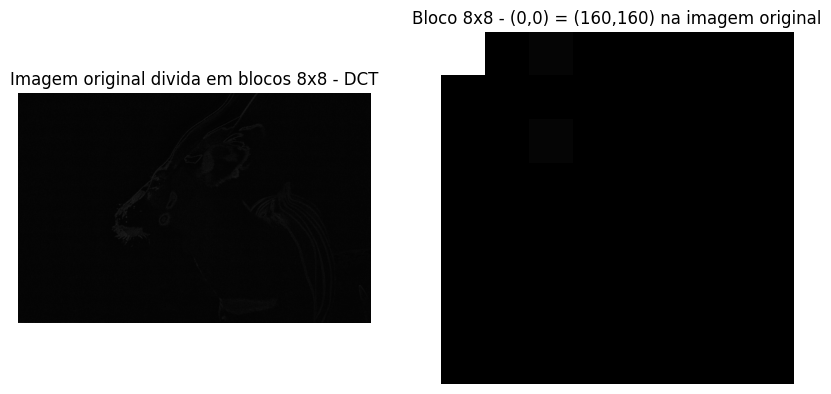

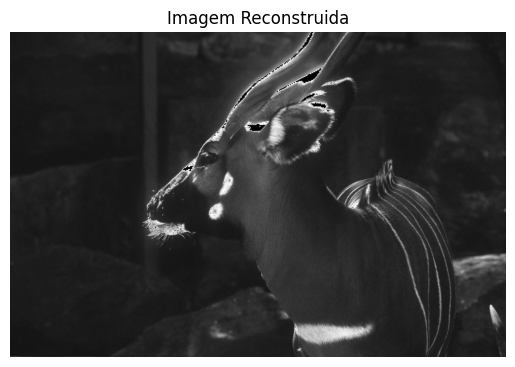

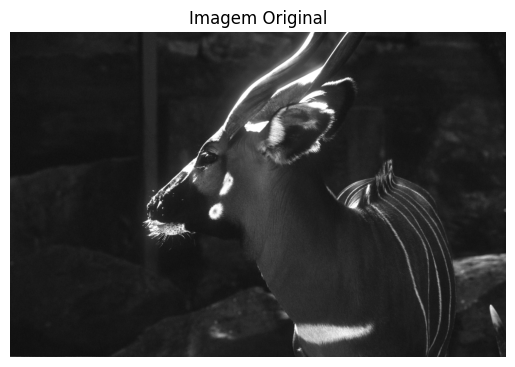

In [532]:
# Informações para execução
img_name = 'deer.pgm'
compacted_img_name = 'dctcomp.txt'

# Leitura da imagem
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height, width = img.shape

# Resize no tamanho se %8 != 0
if ((height % 8 != 0) or (width % 8 != 0)):
    new_height = ((height + 15) // 8) * 8
    new_width = ((width + 15) // 8) * 8
    imagem = cv2.resize(img, (new_width, new_height))
    img = imagem

# Executando a compactação por DCT
DCTWrite(img, compacted_img_name)
DCTRead(img, compacted_img_name)

# Exibindo a imagem original para comparação
plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

# Taxa de compressão
img_size = os.path.getsize(img_name)
compacted_img_size = os.path.getsize(compacted_img_name)
print(f"Taxa de compressão: {img_size/compacted_img_size} : 1")

#Tópico Wavelet

##Funções auxiliares de Decomposição e Reconstrução por Wavelet

###Função Decomposição-Wavelet

In [533]:
"""
    Função que decompõe a imagem utilizando Wavelet
"""
def decomposicao_wavelet(img, keep):
  n = 4
  w = 'db1'

  shape_inicial = img.shape #tamanho inicial

  if (shape_inicial[0]%16 != 0):
    print(f"Erro: Não foi possível decompor a imagem em 4 níveis. a dimensão N={shape_inicial[0]} não é divisível por 16.",'\n')
    return -1,-1
  if (shape_inicial[1]%16 != 0):
    print(f"Erro: Não foi possível decompor a imagem em 4 níveis. a dimensão M={shape_inicial[1]} não é divisível por 16.",'\n')
    return -1,-1

  coeffs_ = pywt.wavedec2(img, wavelet=w, level=n)

  mat_coeff, slices_coeff = pywt.coeffs_to_array(coeffs_)

  Csort = np.sort(np.abs(mat_coeff.reshape(-1)))

  #quantizando a matriz de coeficientes de acordo com o thresholding em keep

  thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
  ind = np.abs(mat_coeff) > thresh
  mat_quantizado = mat_coeff * ind #removendo os valores menores que o threshold
  mat_processado = np.round(mat_quantizado).astype(np.int16)

  return mat_processado, shape_inicial

###Função Reconstrução-Wavelet

Reconstroi a imagem decomposta na função anterior

In [534]:
"""
    Função que reconstrói a imagem utilizando Wavelet
"""
def reconstrucao_wavelet(vetor_coeffs, img_size):
  #Cria bloco de 0's para obter os slices corretos
  n = 4
  w = 'db1'

  mat_padrao = np.zeros(img_size)
  coeficientes_zerados = pywt.wavedec2(mat_padrao, wavelet=w, level=n)
  vetor_zeros, slices_originais = pywt.coeffs_to_array(coeficientes_zerados) ##Slices originais tem o tamanho da matriz original, sendo possivel reconstruir perfeitamente.

  #Reconstruindo a matriz original a partir dos vetores recebidos e do tamanho recebido como parâmetro.
  coeficientes_filtrados = pywt.array_to_coeffs(vetor_coeffs, slices_originais, output_format='wavedec2')
  img_reconstruida = pywt.waverec2(coeficientes_filtrados, wavelet=w)

  return img_reconstruida


##Wavelet - Testes + Aplicação Direta

###Testes com WAVELET

Examinando e testando as funções de decomposição em wavelet e reconstrução em wavelet da biblioteca PYWT.

Entropia 0.1 é: 0.8267213327766001
Entropia 0.04 é: 0.3988372214149931
Entropia 0.01 é: 0.12360342839841425
Entropia 0.005 é: 0.06475765002711287


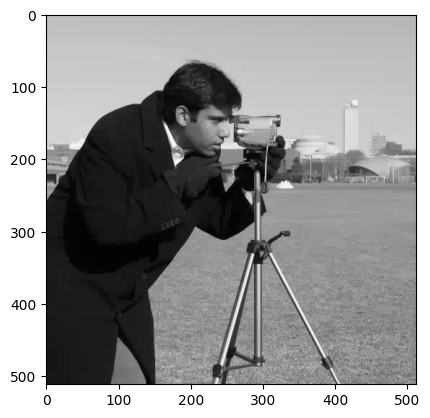

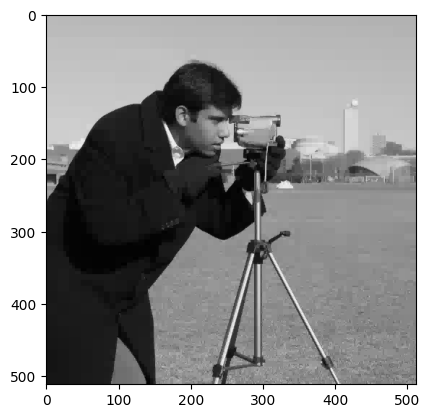

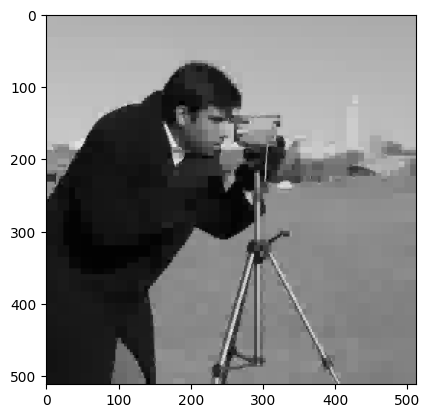

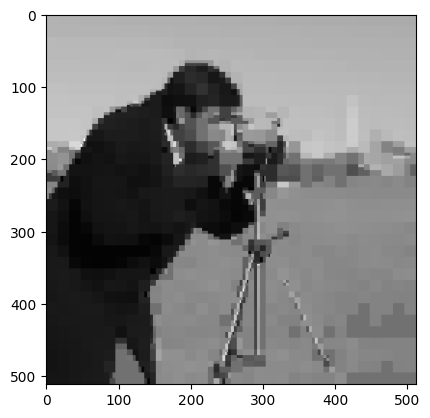

In [535]:
""" Testes para garantir o funcionamento adequado da DWT """
cman = pywt.data.camera()
cman = cman.astype(np.int16)
cman = np.subtract(cman,128)

n = 4
w = 'db1'
shape_img = cman.shape
coeffs = pywt.wavedec2(cman, wavelet=w, level=n)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

for keep in (0.1, 0.04, 0.01, 0.005):
  thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
  ind = np.abs(coeff_arr) > thresh
  Cfilt = coeff_arr * ind ##Filtrando os coeffs
  Cfilt = np.round(Cfilt).astype(np.int16)
  entropia_loopatual = entropiacalc(Cfilt)
  print(f"Entropia {keep} é: {entropia_loopatual}")

  coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')
  ##necessário compactar: coeff_slices, w (header) --> Cfilt(huffman)

  cman_recon = pywt.waverec2(coeffs_filt, wavelet=w)
  cman_recon_processed = np.abs(np.add(np.round(cman_recon),128))
  cman_recon_processed = np.round(cman_recon_processed)
  cman_recon_processed = cman_recon_processed.astype(np.int16)
  plt.figure()
  plt.imshow(cman_recon_processed, cmap='gray')


###Codigo Wavelet (Prática)

Compressão Direta utilizando Transformada Discreta de Wavelet



In [536]:
"""
    Função que recebe a imagem e comprime usando DWT

    :param imagem: imagem a ser compactada
    :param limite: limite para pegar coeficientes na WT
    :param nome_arquivo_comprimido: arquivo que receberá a compactação
"""
def DWTWrite(imagem, limite, nome_arquivo_comprimido):
  original = imagem
  height, width = imagem.shape

  base = original
  base = base.astype(np.int16)
  base = np.subtract(base,128)

  mat_c, base_tam = decomposicao_wavelet(base, limite)
  entropia_mat = entropiacalc(mat_c)
  print(f"Entropia da matriz quantizada mantendo = {limite} : {entropia_mat}",'\n')

  mat_test = rle_encode(mat_c)
  HuffmanWriteTest(mat_test, base_tam, nome_arquivo_comprimido)

In [537]:
"""
    Função que recebe o arquivo comprimido e descomprime usando DWT

    :param imagem: imagem original utilizada APENAS PARA calcular PSNR e MSE
    :param limite: limite para pegar coeficientes na WT
    :param nome_arquivo_comprimido: arquivo compactado
"""
def DWTRead(imagem, limite, nome_arquivo_comprimido):
    matrix, size = HuffmanReadTest(nome_arquivo_comprimido)
    matrix = refaz(matrix)

    reconstructed_matrix = rle_decode_to_ndarray(matrix)
    base_recon = reconstrucao_wavelet(reconstructed_matrix, size)
    base_recon = np.add(base_recon, 128)
    resultado = np.abs(np.round(base_recon))

    plt.figure()
    plt.imshow(resultado.astype(np.uint8), cmap='gray')
    plt.axis('off')
    plt.title(f"Imagem Reconstruida mantendo {np.round(limite*100,2)}% dos coeficientes")

    print(f"MSE = {MSE_calc(imagem, resultado.astype(np.uint8))}")
    print(f"PSNR = {PSNR_calc(imagem, resultado.astype(np.uint8))}")

Entropia da matriz quantizada mantendo = 0.05 : 0.5038314378819297 

Lbarra: 1.288224235372401
MSE = 45.8
PSNR = 31.52
Taxa de compressão: 6.015313208354622 : 1


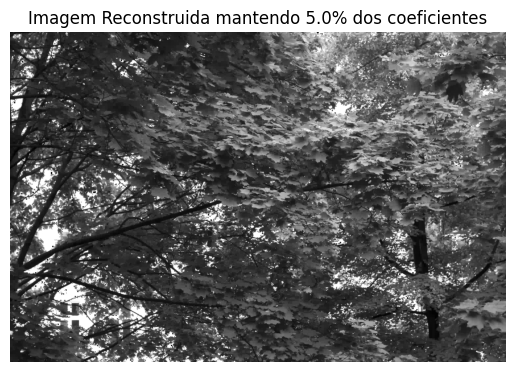

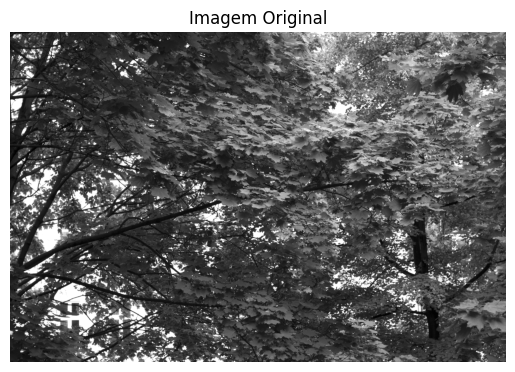

In [538]:
# Informações para execução
img_name = 'leaves_iso_200.pgm'
compacted_img_name = 'dwtcomp.txt'
limit = 0.05

# Leitura da imagem
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height, width = img.shape

# Resize no tamanho se %16 != 0
if ((height % 16 != 0) or (width % 16 != 0)):
    new_height = ((height + 15) // 16) * 16
    new_width = ((width + 15) // 16) * 16
    imagem = cv2.resize(img, (new_width, new_height))
    img = imagem

# Executando a compactação por DWT
DWTWrite(img, limit, compacted_img_name)
DWTRead(img, limit, compacted_img_name)

# Exibindo a imagem original para comparação
plt.figure()
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

# Taxa de compressão
img_size = os.path.getsize(img_name)
compacted_img_size = os.path.getsize(compacted_img_name)
print(f"Taxa de compressão: {img_size/compacted_img_size} : 1")